### **`Business Understanding`**

**Objective**: The primary objective of this project is to predict fluctuations in the U.S. Dollar Index (DXY) using historical prices of Bitcoin, crude oil, and gold, alongside other influential factors such as economic trends and temporal variables. Additionally, the project aims to utilize these predictions to calculate and assess portfolio risk, providing actionable insights for more informed investment strategies.

**Key Questions:**
1. What are the relationships between Bitcoin, crude oil, and gold prices, and how do they correlate with changes in the U.S. Dollar Index?
2.	To what extent do external features, such as holidays, weekdays, or the DXY itself, influence the accuracy and predictive power of the model?
3.	How can the predictive model be used to calculate and evaluate portfolio risk, helping investors optimize their asset allocation?
4.	What actionable insights can the predictive model offer for market forecasting and portfolio management strategies?

### **`Data Preparation`**

**Objective**: merging different datasets into one

#### **Separate Dataset Preprocessing**
- At the End of this stage we will have different cleaned DataFrames, ready for a left join By date.
    - Standardize column names
    - Proper Dtypes
    - Date properties (holiday, weekday) changed to binary
    - Ensured about date Integrity for all DFs

##### **Importation of Packages and  Reading CSV**

In [1]:
import pandas as pd

In [14]:
df_oil = pd.read_csv('/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/Project/Cleaned Unjoined/cleaned_btc.csv')
df_gold = pd.read_csv('/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/Project/Cleaned Unjoined/cleaned_gold.csv')
# df_dxy = pd.read_csv('/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/Project/Cleaned Unjoined/cleaned_dxy.csv')
df_btc = pd.read_csv('/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/Project/Cleaned Unjoined/cleaned_btc.csv')
df_date = pd.read_csv('/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/Project/Cleaned Unjoined/date.csv')
# df_holiday = pd.read_csv('/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/Project/Cleaned Unjoined/holiday.csv')
# df_weekday = pd.read_csv('/Users/h.h/Downloads/BAnDS/Fall 2024/5193 -  Programming I DS/Project/Cleaned Unjoined/weekday.csv')


##### **Oil DataFrame Preprocessing**

In [5]:
df_oil.head()

,Date,btc_open,btc_high,btc_low,btc_close
0,2024-10-21,69009.37,69408.10,66873.84,67525.97
1,2024-10-20,68364.18,69359.01,68105.72,69001.70
2,2024-10-19,68418.98,68668.01,68024.64,68362.73
3,2024-10-18,67419.11,68969.75,67177.82,68418.79
4,2024-10-17,67617.08,67912.21,66647.39,67399.84


In [6]:
df_oil.dtypes

Date          object
btc_open     float64
btc_high     float64
btc_low      float64
btc_close    float64
dtype: object

In [7]:
# Convert Date to datetime
df_oil['Date'] = pd.to_datetime(df_oil['Date'])

In [8]:
df_oil.shape

(3643, 5)

In [24]:
# Check for start and end date
df_oil['Date'].min(), df_oil['Date'].max()

(Timestamp('2014-11-01 00:00:00'), Timestamp('2024-10-21 00:00:00'))

##### **Gold DataFrame Preprocessing**

In [27]:
df_gold.head()

,Date,gold_close,gold_open,gold_high,gold_low
0,2024-11-06,2668.0,2754.4,2758.7,2660.75
1,2024-11-05,2749.7,2746.0,2759.5,2733.40
2,2024-11-04,2746.2,2743.5,2757.5,2739.40
3,2024-11-01,2749.2,2754.0,2772.4,2742.60
4,2024-10-31,2749.3,2799.1,2801.2,2741.80


In [ ]:
df_gold.dtypes

Date          object
gold_close    object
gold_open     object
gold_high     object
gold_low      object
dtype: object

In [ ]:
# Convert Date to datetime
df_gold['Date'] = pd.to_datetime(df_gold['Date'])

In [ ]:
# Covert Object to Float
for col in ["gold_close", "gold_open", "gold_high", "gold_low"]:
    df_gold[col] = df_gold[col].str.replace(',', '').astype(float)

In [35]:
df_gold.shape

(2568, 5)

In [ ]:
# Check for start and end date
df_gold['Date'].min(), df_gold['Date'].max()

(Timestamp('2014-11-03 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **BTC DataFrame Preprocessing**

In [30]:
df_btc.head()

,Date,btc_open,btc_high,btc_low,btc_close
0,2024-10-21,69009.37,69408.10,66873.84,67525.97
1,2024-10-20,68364.18,69359.01,68105.72,69001.70
2,2024-10-19,68418.98,68668.01,68024.64,68362.73
3,2024-10-18,67419.11,68969.75,67177.82,68418.79
4,2024-10-17,67617.08,67912.21,66647.39,67399.84


In [31]:
df_btc.dtypes

Date          object
btc_open     float64
btc_high     float64
btc_low      float64
btc_close    float64
dtype: object

In [34]:
df_btc.shape

(3643, 5)

In [32]:
# Convert Date to datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'])

In [33]:
# Check for start and end date
df_gold['Date'].min(), df_gold['Date'].max()

(Timestamp('2014-11-03 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **DXY DataFrame Preprocessing**

In [ ]:
# df_dxy.head()

,Date,gold_close,gold_open,gold_high,gold_low
0,2024-11-06,"2,668.00","2,754.40","2,758.70","2,660.75"
1,2024-11-05,"2,749.70","2,746.00","2,759.50","2,733.40"
2,2024-11-04,"2,746.20","2,743.50","2,757.50","2,739.40"
3,2024-11-01,"2,749.20","2,754.00","2,772.40","2,742.60"
4,2024-10-31,"2,749.30","2,799.10","2,801.20","2,741.80"


In [ ]:
## drop  vol, change columns
# df_dxy = df_dxy.drop(columns=['Vol.', 'Change %'])

In [ ]:
# df_dxy.dtypes

Date          object
gold_close    object
gold_open     object
gold_high     object
gold_low      object
dtype: object

In [ ]:
# # Convert Date to datetime
# df_dxy['Date'] = pd.to_datetime(df_dxy['Date'])

In [ ]:
# df_dxy.shape

In [ ]:
# # Check for start and end date
# df_dxy['Date'].min(), df_dxy['Date'].max()

(Timestamp('2014-11-03 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **Date DataFrame Preprocessing**

In [36]:
df_date.head()

,Unnamed: 0,Date,DoW,Month,Year
0,0,2014-11-01,Saturday,11,2014
1,1,2014-11-02,Sunday,11,2014
2,2,2014-11-03,Monday,11,2014
3,3,2014-11-04,Tuesday,11,2014
4,4,2014-11-05,Wednesday,11,2014


In [37]:
df_date = df_date.drop(columns=['Unnamed: 0'])

In [38]:
df_date['Date'] = pd.to_datetime(df_date['Date'])

In [39]:
df_date.shape

(3653, 4)

In [40]:
df_date['Date'].min(), df_date['Date'].max()

(Timestamp('2014-11-01 00:00:00'), Timestamp('2024-10-31 00:00:00'))

##### **Holiday DataFrame Preprocessing**

In [41]:
# df_holiday = df_holiday[['Date','Title']]

In [42]:
# df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])

In [43]:
# df_holiday.dtypes

##### **Weekday DataFrame Preprocessing**

In [44]:
# df_weekday.head()

In [45]:
# df_weekday['Date'] = pd.to_datetime(df_weekday['A_DATE'])

In [46]:
# # impute missing values with 0
# df_weekday['IS_HOLIDAY'] = df_weekday['IS_HOLIDAY'].fillna(0)

#### **Joining Stage**
- The Final Table
    - Daily Open, High, Low, Close Prices of commodities 
    - Daily Open, High, Low, Close Prices of Dollar Index
    - Date properties (holiday, weekday)
    - Proper Dtypes

In [ ]:
# # merge all dataframes
# df = df_date \
#     .merge(df_btc, on='Date', how='left') \
#     .merge(df_oil, on='Date', how='left') \
#     .merge(df_gold, on='Date', how='left') \
#     .merge(df_dxy, on='Date', how='left') \
#     .merge(df_weekday, on='Date', how='left') \
#     .merge(df_holiday, on='Date', how='left')

In [ ]:
# df.head(10)

In [50]:
# df = df.sort_values(by='Date', ascending=False)

### **`Data Understanding`**

In [2]:
# Descriptive Analytics Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

# Time Series Analysis Packages
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning Packages
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor , XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import shap
from sklearn.inspection import PartialDependenceDisplay



# Data Manipulations & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preparation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA

# from imblearn.pipeline import Pipeline as imbpipeline
# from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

#Model Persistance
import joblib


#Utilities
import warnings
sns.set_style('darkgrid')
import os

In [3]:
pd.set_option('display.max_columns' , None)
pd.set_option('display.max_rows' , None)

In [4]:
# Not Necessary
# Get the current directory of the script
current_dir = os.getcwd()

# Go back one folder and then to 'datasets'
csv_path = os.path.join(current_dir, "..", "datasets", "final_dataset.csv")

# Normalize the path for platform independence
csv_path = os.path.normpath(csv_path)
df = pd.read_csv(csv_path)
df.head()

#### **Data Cleaning**

In [7]:
# Not Necessary
df.drop(columns='Unnamed: 0', inplace=True)

In [9]:
# Not Necessary
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.isna().sum()

Date             0
DoW              0
Month            0
Year             0
btc_open        10
btc_high        10
btc_low         10
btc_close       10
oil_close     1016
oil_open      1016
oil_high      1016
oil_low       1016
gold_close    1089
gold_open     1089
gold_high     1089
gold_low      1089
dxy_close     1043
dxy_open      1043
dxy_high      1043
dxy_low       1043
IS_HOLIDAY       0
IS_WEEKDAY       0
Title         3549
dtype: int64

In [10]:
df['Date'].min(), df['Date'].max()

(Timestamp('2014-11-01 00:00:00'), Timestamp('2024-10-31 00:00:00'))

In [11]:
# Not Necessary
numeric_columns = ['gold_open', 'gold_high', 'gold_low', 'gold_close'] 
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')


In [12]:
df.columns

Index(['Date', 'DoW', 'Month', 'Year', 'btc_open', 'btc_high', 'btc_low',
       'btc_close', 'oil_close', 'oil_open', 'oil_high', 'oil_low',
       'gold_close', 'gold_open', 'gold_high', 'gold_low', 'dxy_close',
       'dxy_open', 'dxy_high', 'dxy_low', 'IS_HOLIDAY', 'IS_WEEKDAY', 'Title'],
      dtype='object')

In [13]:
##### Rearranging columns for easier analysis
new_column_order = ['Date', 'DoW', 'Month', 'Year', 
                    'btc_open', 'btc_high', 'btc_low','btc_close',
                    'oil_open', 'oil_high', 'oil_low', 'oil_close', 
                    'gold_open', 'gold_high', 'gold_low', 'gold_close',
                    'dxy_open', 'dxy_high', 'dxy_low', 'dxy_close', 
                    'IS_HOLIDAY', 'IS_WEEKDAY', 'Title']

df = df[new_column_order]

In [14]:
df.rename(columns={'Title': 'Holiday_Name'}, inplace=True)

In [15]:
df.head()

,Date,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_open,oil_high,oil_low,oil_close,gold_open,gold_high,gold_low,gold_close,dxy_open,dxy_high,dxy_low,dxy_close,IS_HOLIDAY,IS_WEEKDAY,Holiday_Name
0,2024-10-31,Thursday,10,2024,NaN,NaN,NaN,NaN,69.10,70.81,68.30,69.26,2799.1,2801.2,2741.8,2749.3,104.08,104.22,103.82,103.98,0.0,1,NaN
1,2024-10-30,Wednesday,10,2024,NaN,NaN,NaN,NaN,67.47,69.17,67.28,68.61,2786.9,2801.8,2782.4,2800.8,104.25,104.44,103.98,103.99,0.0,1,NaN
2,2024-10-29,Tuesday,10,2024,NaN,NaN,NaN,NaN,68.02,68.52,66.72,67.21,2741.9,2773.2,2741.9,2768.8,104.31,104.64,104.21,104.32,0.0,1,NaN
3,2024-10-28,Monday,10,2024,NaN,NaN,NaN,NaN,68.98,69.00,66.92,67.38,2749.2,2758.3,2736.9,2755.9,104.32,104.57,104.12,104.32,0.0,1,NaN
4,2024-10-27,Sunday,10,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN


#### **Exploratory Data Analysis**

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,3653.0,1826.000000,1054.674594,0.00,913.0000,1826.000,2739.0000,3652.00
Month,3653.0,6.522310,3.449345,1.00,4.0000,7.000,10.0000,12.00
Year,3653.0,2019.333425,2.897193,2014.00,2017.0000,2019.000,2022.0000,2024.00
btc_open,3643.0,18449.732976,20039.914540,176.90,1319.8550,9314.130,29848.5850,73079.38
btc_high,3643.0,18865.656794,20480.738577,211.73,1339.5950,9466.350,30391.1100,73750.07
btc_low,3643.0,18008.726780,19563.811246,171.51,1315.0650,9149.390,29307.6250,71334.09
btc_close,3643.0,18467.017137,20052.330675,178.10,1334.8400,9316.630,29859.7400,73083.50
oil_close,2637.0,61.870300,17.522667,11.57,48.7000,59.640,74.1300,119.78
oil_open,2637.0,61.894638,17.514253,18.01,48.7900,59.650,74.1800,120.66
oil_high,2637.0,62.903367,17.769240,19.66,49.4600,60.500,75.3100,126.42


##### **Distribution Analysis**

[]

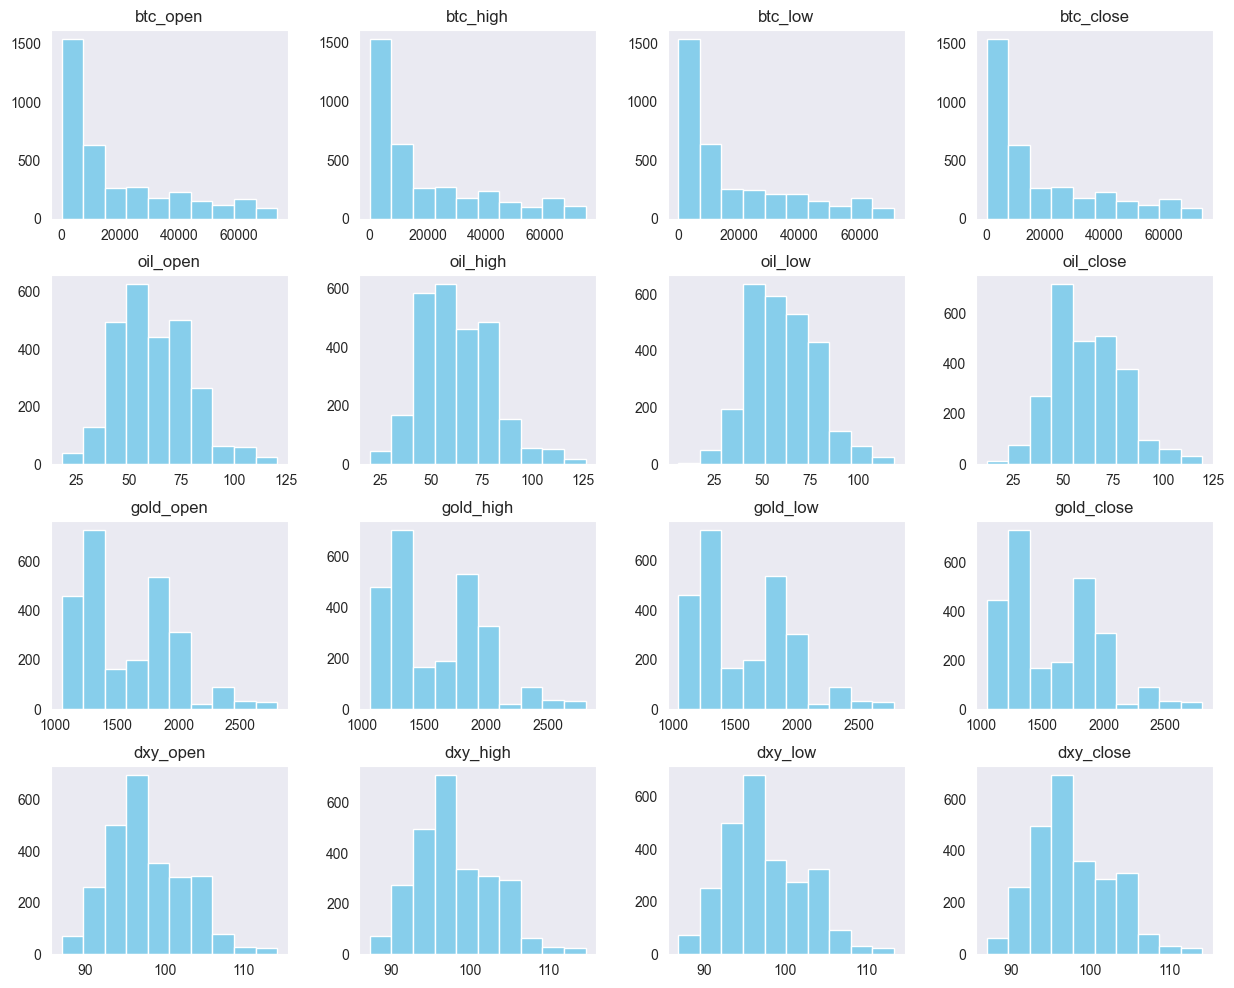

In [16]:
df.drop(columns=['Date', 'Month', 'Year', 'IS_HOLIDAY', 'IS_WEEKDAY']).hist(grid=False, color='skyblue', figsize=(15, 12) )
plt.plot()

##### **Correlation Analysis**

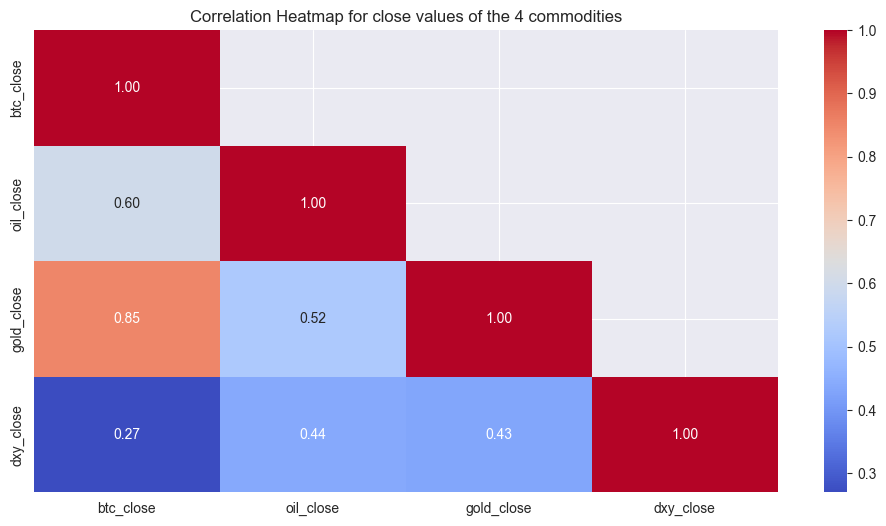

In [18]:
correlation_matrix = df[['btc_close', 'oil_close', 'gold_close', 'dxy_close']].corr().round(2)

# Modify the mask to exclude the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plot the heatmap with the modified mask to include the diagonal
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap for close values of the 4 commodities")
plt.show()

##### **Time Series Analysis**

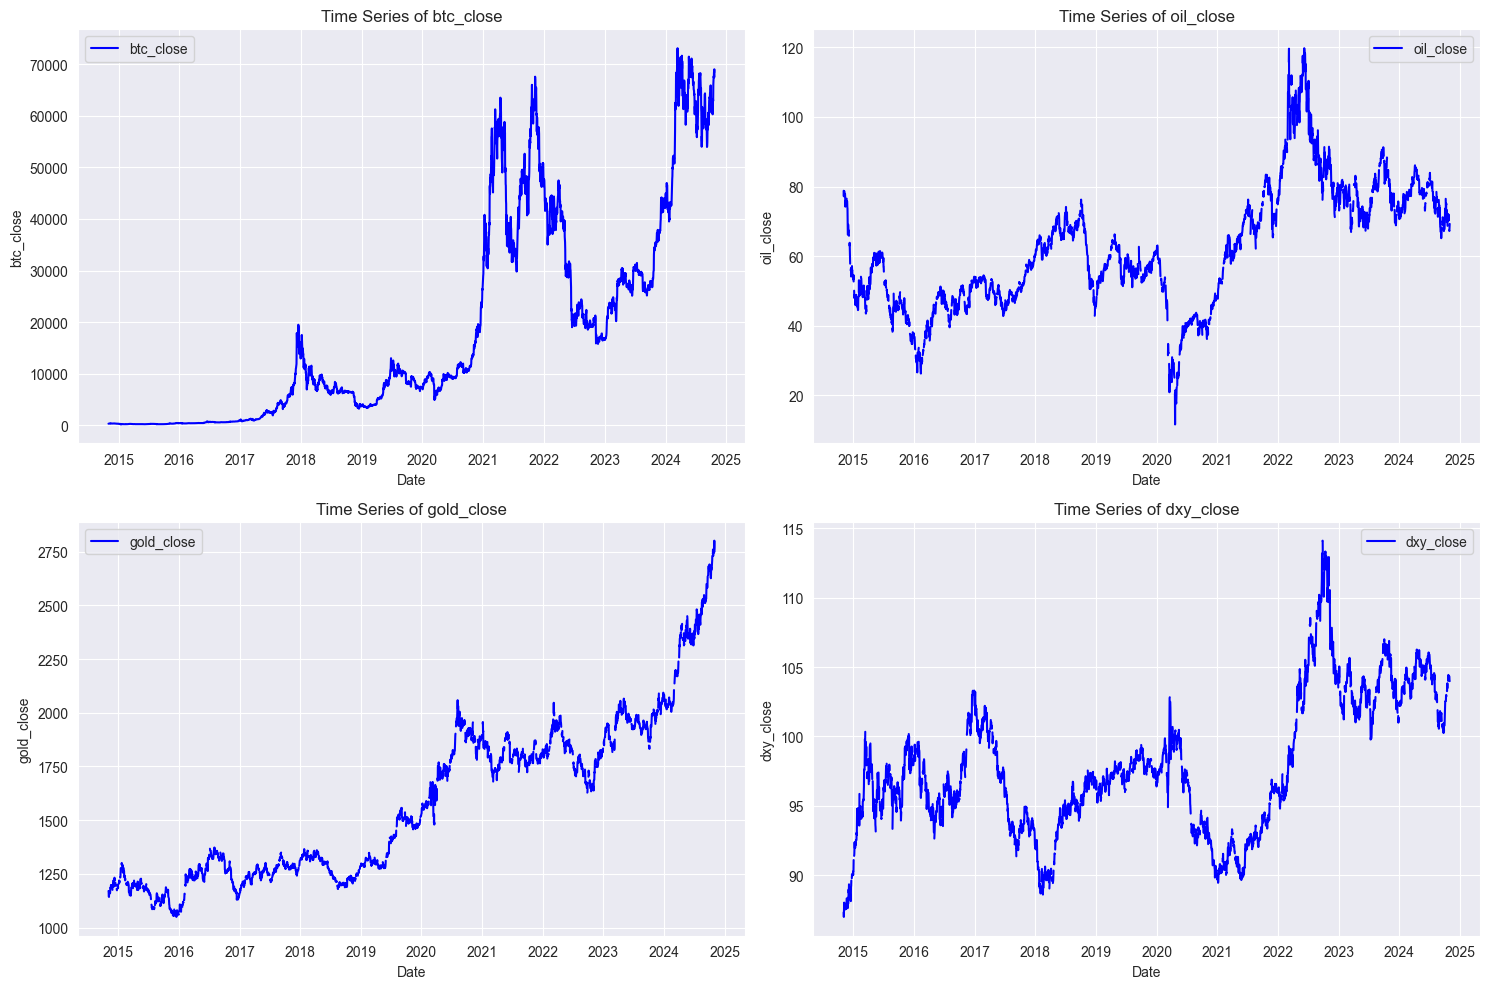

In [19]:
# Set Date as the index for time series analysis
df.set_index('Date', inplace=True)

# Ensure the dataset is sorted by date in ascending order
df = df.sort_index(ascending=True)


# List of variables to analyze
variables = ['btc_close', 'oil_close', 'gold_close', 'dxy_close']

# Plot time series of each variable
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 2, i+1)
    plt.plot(df[var], label=var, color='blue')
    plt.title(f"Time Series of {var}")
    plt.xlabel("Date")
    plt.ylabel(var)
    plt.legend()

plt.tight_layout()
plt.show()

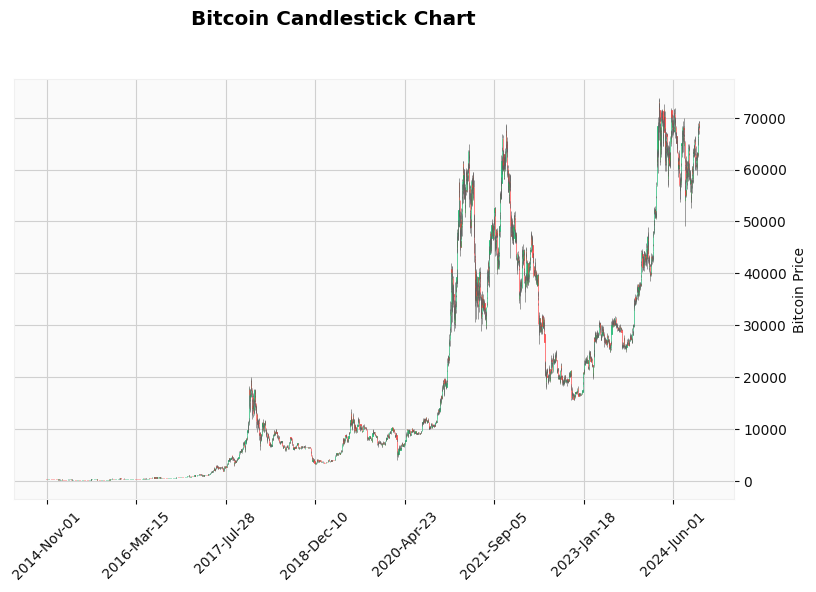

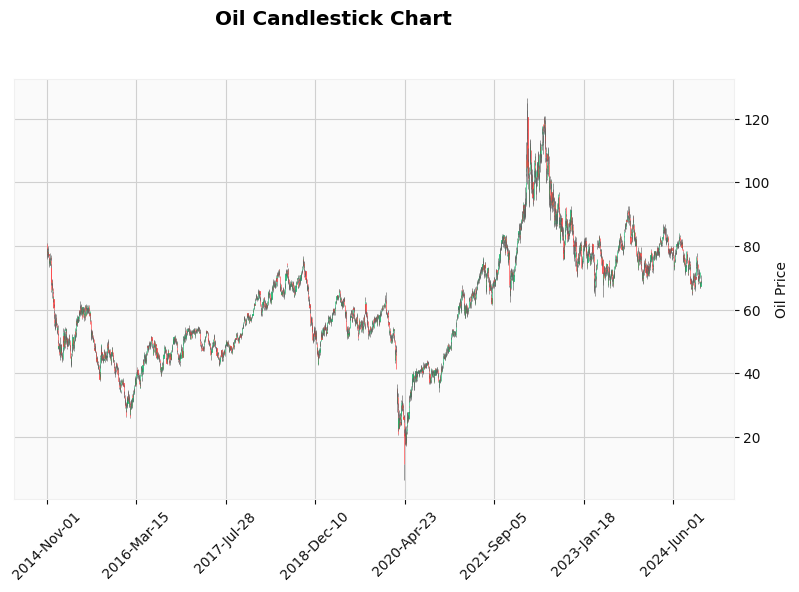

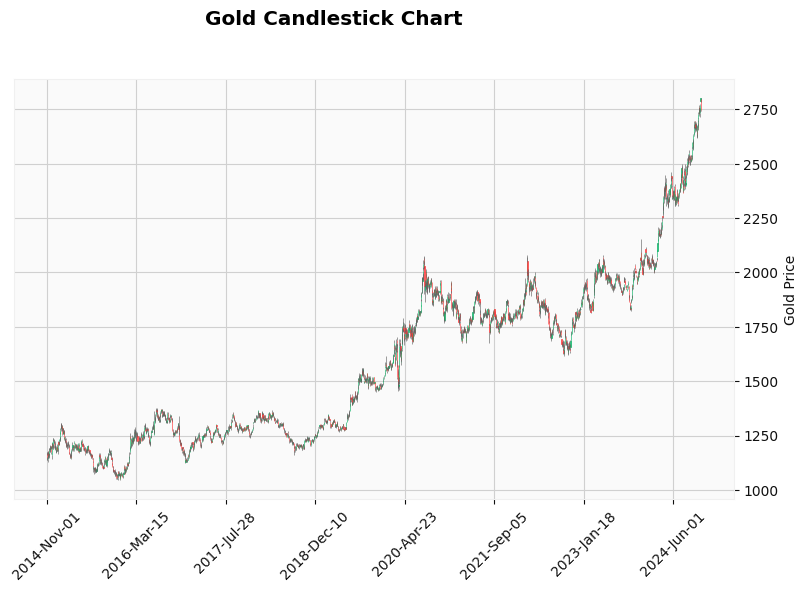

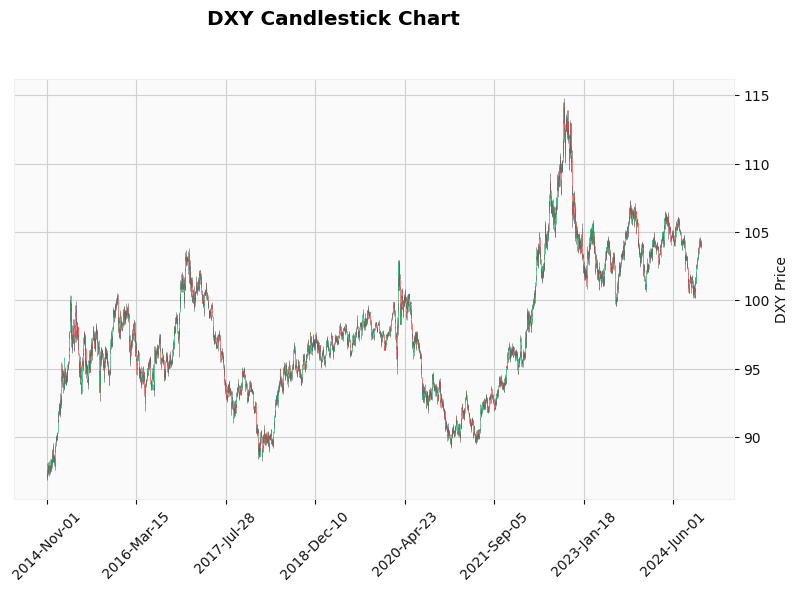

In [24]:
# List of commodities and their relevant columns
commodities = {
    'Bitcoin': ['btc_open', 'btc_high', 'btc_low', 'btc_close'],
    'Oil': ['oil_open', 'oil_high', 'oil_low', 'oil_close'],
    'Gold': ['gold_open', 'gold_high', 'gold_low', 'gold_close'],
    'DXY': ['dxy_open', 'dxy_high', 'dxy_low', 'dxy_close']
}

# Plot candlestick charts for each commodity
for name, columns in commodities.items():
    # Subset the data for the specific commodity
    df_commodity = df[columns]
    df_commodity.columns = ['Open', 'High', 'Low', 'Close']  # Rename for mplfinance compatibility
    df_commodity['Date'] = df.index  # Reset Date from index
    df_commodity.set_index('Date', inplace=True)
    
    # Generate the candlestick chart
    mpf.plot(
        df_commodity,
        type='candle',
        title=f'{name} Candlestick Chart',
        style='yahoo',
        ylabel=f'{name} Price',
        figsize=(10, 6)
    )

##### **Addictive and Multiplicative Decompositions**

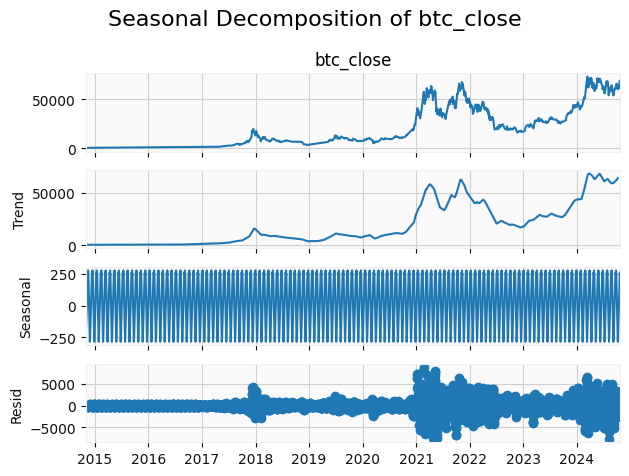

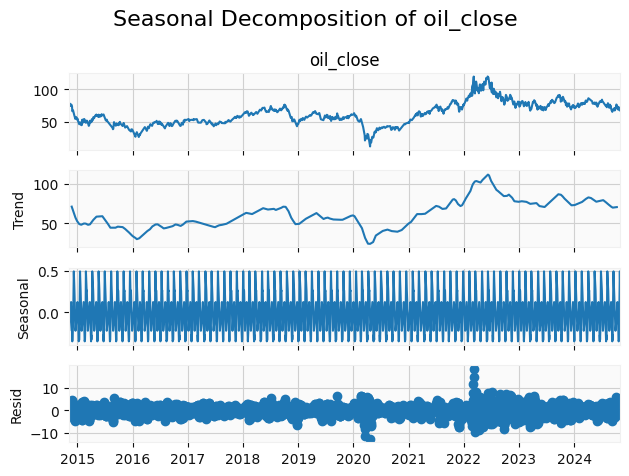

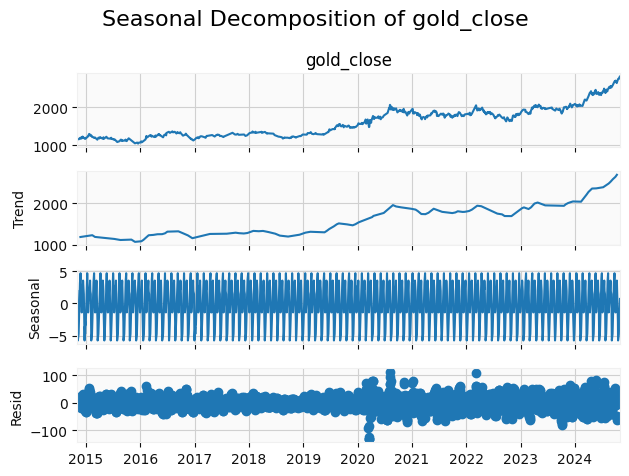

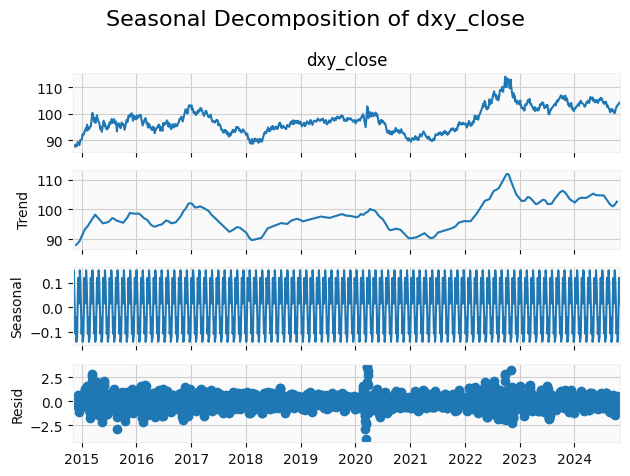

In [25]:
for variable in variables:
    decomposition = seasonal_decompose(df[variable].dropna(), model='additive', period=30)
    fig = decomposition.plot()
    fig.suptitle("") 
    plt.subplots_adjust(top=0.85) 
    plt.gcf().text(0.5, 0.95, f"Seasonal Decomposition of {variable}", fontsize=16, ha='center') 
    plt.show()

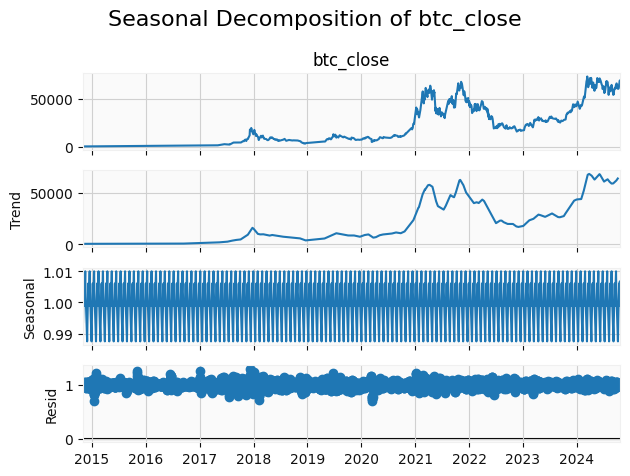

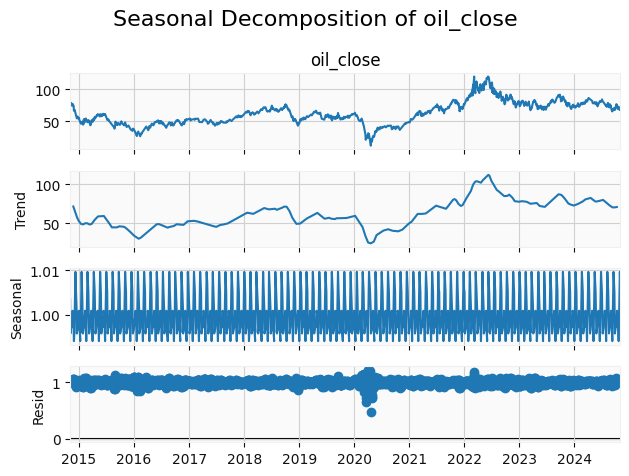

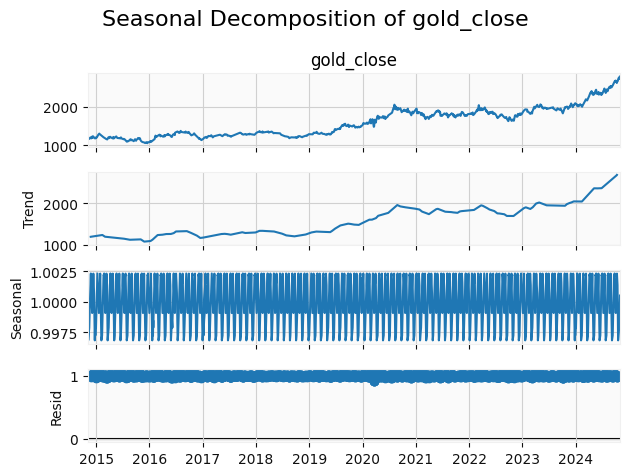

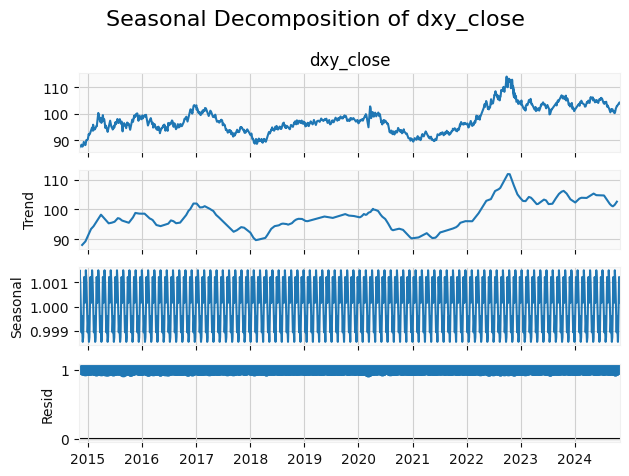

In [26]:
for variable in variables:
    decomposition = seasonal_decompose(df[variable].dropna(), model='multiplicative', period=30)
    fig = decomposition.plot()
    fig.suptitle("") 
    plt.subplots_adjust(top=0.85)  
    plt.gcf().text(0.5, 0.95, f"Seasonal Decomposition of {variable}", fontsize=16, ha='center')  
    plt.show()

##### **Outlier Analysis**

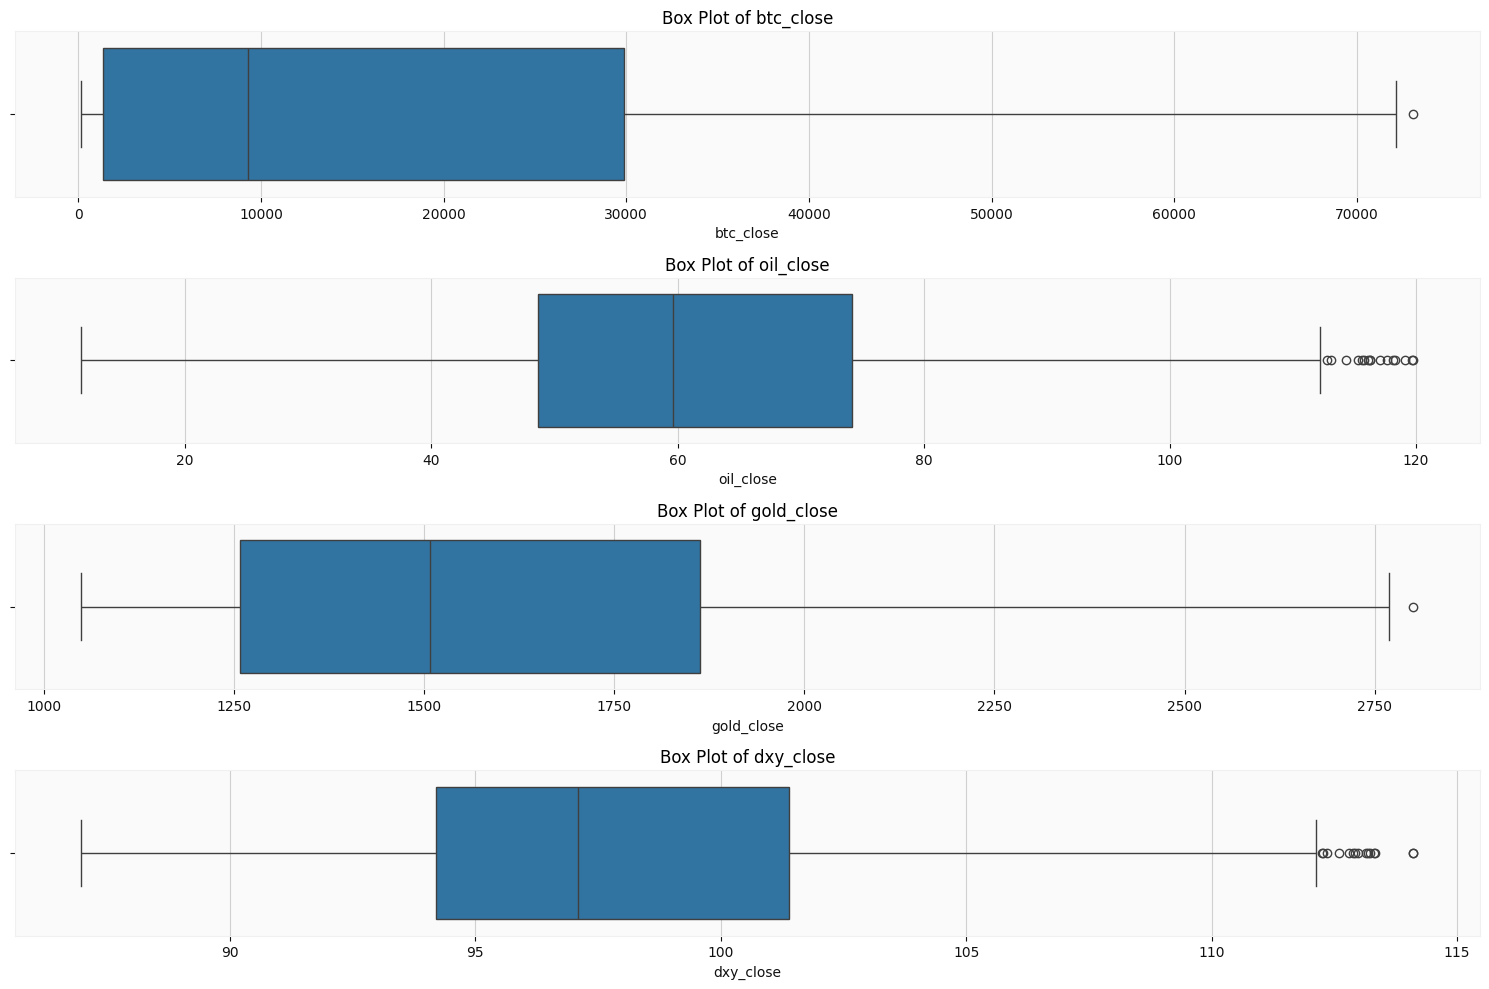

In [36]:
# List of columns to create boxplots for
variables = ['btc_close', 'oil_close', 'gold_close', 'dxy_close']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10), sharex=False)

# Generate horizontal boxplots for each variable
for i, var in enumerate(variables):
    sns.boxplot(x=df[var], ax=axes[i], orient='h')
    axes[i].set_title(f"Box Plot of {var}")
    axes[i].set_xlabel(var)

# Adjust layout
plt.tight_layout()
plt.show()

### **`Data Understanding`**